In [1]:
#!/usr/bin/env python
import argparse
import json
import os
from typing import Any, Iterable, Mapping, Tuple

import numpy as np
import sklearn
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler

from config import CONFIG_BY_KEY, Config
from data_loader import DataHelper, DataLoader

In [2]:
def train_io(config: Config, data: DataLoader, train_index: Iterable[int],
             test_index: Iterable[int]) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    train_input, train_output = data.get_split(train_index)
    test_input, test_output = data.get_split(test_index)

    datahelper = DataHelper(train_input, train_output, test_input, test_output, config, data)

    train_input = np.empty((len(train_input), 0))
    test_input = np.empty((len(test_input), 0))

    if config.use_target_text:
        if config.use_bert:
            train_input = np.concatenate([train_input, datahelper.get_target_bert_feature(mode="train")], axis=1)
            test_input = np.concatenate([test_input, datahelper.get_target_bert_feature(mode="test")], axis=1)
        else:
            train_input = np.concatenate([train_input,
                                          np.array([datahelper.pool_text(utt)
                                                    for utt in datahelper.vectorize_utterance(mode="train")])], axis=1)
            test_input = np.concatenate([test_input,
                                         np.array([datahelper.pool_text(utt)
                                                   for utt in datahelper.vectorize_utterance(mode="test")])], axis=1)

    if config.use_target_video:
        train_input = np.concatenate([train_input, datahelper.get_target_video_pool(mode="train")], axis=1)
        test_input = np.concatenate([test_input, datahelper.get_target_video_pool(mode="test")], axis=1)

    if config.use_target_audio:
        train_input = np.concatenate([train_input, datahelper.get_target_audio_pool(mode="train")], axis=1)
        test_input = np.concatenate([test_input, datahelper.get_target_audio_pool(mode="test")], axis=1)

    if train_input.shape[1] == 0:
        raise ValueError("Invalid modalities")

    # Aux input

    if config.use_author:
        train_input_author = datahelper.get_author(mode="train")
        test_input_author = datahelper.get_author(mode="test")

        train_input = np.concatenate([train_input, train_input_author], axis=1)
        test_input = np.concatenate([test_input, test_input_author], axis=1)

    if config.use_context:
        if config.use_bert:
            train_input_context = datahelper.get_context_bert_features(mode="train")
            test_input_context = datahelper.get_context_bert_features(mode="test")
        else:
            train_input_context = datahelper.get_context_pool(mode="train")
            test_input_context = datahelper.get_context_pool(mode="test")

        train_input = np.concatenate([train_input, train_input_context], axis=1)
        test_input = np.concatenate([test_input, test_input_context], axis=1)

    train_output = datahelper.one_hot_output(mode="train", size=config.num_classes)
    test_output = datahelper.one_hot_output(mode="test", size=config.num_classes)

    return train_input, train_output, test_input, test_output

In [3]:
config = CONFIG_BY_KEY['tav']
data = DataLoader(config)
for _ in range(config.runs):
    for fold, (train_index, test_index) in enumerate(data.get_stratified_k_fold()):
        config.fold = fold + 1
        train_input, train_output, test_input, test_output = train_io(config=config, data=data, train_index=train_index,
                                                                      test_index=test_index)


In [4]:
train_output.shape

(552, 2)

In [5]:
train_input.shape

(552, 3099)

In [6]:
clf = make_pipeline(
        StandardScaler() if config.svm_scale else FunctionTransformer(lambda x: x, validate=False),
        svm.SVC(C=config.svm_c, gamma="scale", kernel="rbf")
    )

In [7]:
clf.fit(train_input, np.argmax(train_output, axis=1))

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC(C=10.0))])

In [8]:
y_predict = clf.predict(test_input)
y_true = np.argmax(test_output,axis=1)

In [47]:
conf = confusion_matrix(y_true, y_predict)
print(confusion)

[[54 23]
 [ 6 55]]


In [10]:
 result_string = classification_report(y_true, y_predict, digits=3)
print(result_string)

              precision    recall  f1-score   support

           0      0.781     0.740     0.760        77
           1      0.692     0.738     0.714        61

    accuracy                          0.739       138
   macro avg      0.737     0.739     0.737       138
weighted avg      0.742     0.739     0.740       138



In [11]:
data.data_input[500][7].shape

(768,)

In [12]:
len(data.data_input)

690

In [13]:
feature_vector = data.data_input[0][4]

In [14]:
 audio_numpy = np.array(np.mean(feature_vector, axis=1))

In [15]:
audio_numpy.shape

(283,)

In [16]:
samp_inp = data.data_input[2][7]

In [17]:
feature_vector1 = data.data_input[0][5]

In [18]:
video_numpy = np.array(np.mean(feature_vector1, axis=0))

In [19]:
video_numpy.shape

(2048,)

In [20]:
zeros_array = np.zeros(2331)

In [21]:
samp_int = np.concatenate([samp_inp,zeros_array])

In [22]:
samp_int = [samp_int]

In [23]:
test_input[0].shape

(3099,)

In [24]:
samp_int

[array([ 0.4107975 , -0.53687675, -0.27089625, ...,  0.        ,
         0.        ,  0.        ])]

In [25]:
samp_inp1 = data.data_input[4][7]

In [26]:
zeros_array = np.zeros(2331)
samp_int1 = np.concatenate([samp_inp1,zeros_array])
samp_int1 = [samp_int1]

In [27]:
clf.predict(samp_int1)

array([1], dtype=int64)

In [28]:
tst_inp = [test_input[0]]
tst_inp

[array([ 1.57187500e-01, -6.09150000e-01, -1.24935750e-01, ...,
        -4.90012361e-06, -1.70604536e-05,  2.00549024e+03])]

In [29]:
clf.predict(test_input)

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int64)

In [30]:
clf.predict([test_input[2]])

array([0], dtype=int64)

In [64]:
samp_int2 = data.data_input[1][7]

In [65]:
samp_int2.shape

(768,)

In [66]:
zeros_array = np.zeros(2331)
samp_int2 = np.concatenate([samp_int2,zeros_array])

In [67]:
samp_int2

array([ 0.6363785 , -0.16601725, -0.144872  , ...,  0.        ,
        0.        ,  0.        ])

In [68]:
res = clf.predict([samp_int2])

In [60]:
if res[0] == 0:
    print("not sarcastic")
else:
    print("sarcastic")

not sarcastic


In [37]:
data.data_input[4][7].shape

(768,)

In [38]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [39]:
rf.fit(train_input,np.argmax(train_output, axis=1))

RandomForestClassifier()

In [40]:
y_pred = rf.predict(test_input)
y_tr = np.argmax(test_output, axis=1)

In [41]:
confusion = confusion_matrix(y_tr, y_pred)
print(confusion)

[[54 23]
 [ 6 55]]


In [42]:
result_string = classification_report(y_tr, y_pred, digits=3)
print(result_string)

              precision    recall  f1-score   support

           0      0.900     0.701     0.788        77
           1      0.705     0.902     0.791        61

    accuracy                          0.790       138
   macro avg      0.803     0.801     0.790       138
weighted avg      0.814     0.790     0.790       138



In [43]:
# Import the average_precision_score function
from sklearn.metrics import average_precision_score
# Calculate and print the average precision score for each class
aps = average_precision_score(y_true, y_predict)
print(f'Average precision score: {aps}')

Average precision score: 0.6266608183928212


In [44]:
aps = average_precision_score(y_tr, y_pred)
print(f'Average precision score: {aps}')

Average precision score: 0.6792495933622092


In [45]:
train_input.shape

(552, 3099)

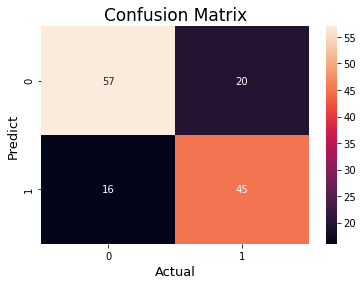

In [48]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 
sns.heatmap(conf, 
			annot=True,
			fmt='g')
plt.ylabel('Predict',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [63]:
str1 = "It's just a privilege to watch your mind at work."

In [69]:
res = clf.predict([samp_int2]) #samp_int2 is here after feature extraction

if res[0] == 0:
    print("not sarcastic")
else:
    print("sarcastic")

sarcastic
